In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

<p> helper functions and classes </p>

In [25]:
def see_data_stored(data_from_customDataFunction):
  x = print('\nFirst iteration of data set: ', next(iter(data_from_customDataFunction)), '\n') # Display text and label.
  y =print('Length of data set: ', len(data_from_customDataFunction), '\n')                  # Print how many items are in the data set
  #z = print('Entire data set: ', list(DataLoader(data_from_customDataFunction)), '\n')        # Print entire data set
  return x,y

In [26]:
class SeabornFigToGrid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

### Prepare data

<p> LOAD LALONDE DATASET </p>

In [75]:
'''
Load the two datasets.
nsw = Male sub sample of treated and control units as used by Lalonde.
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

'''

nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)


nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')

nswre74_pd_df = pd.concat([nswre74_control,nswre74_treated]) #Combine treatment into a single control as pandas dataframe

#Shuffle data sets 
nswre74_pd_df = shuffle(nswre74_pd_df).reset_index(drop=True)
nsw_pd_df = shuffle(nsw).reset_index(drop=True)


<P> LOAD SIMULATED DATASET</P>

In [76]:
simulated_dataset = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/simulated_experimental_dataset.csv')
simulated_dataset.drop('Unnamed: 0', axis=1, inplace=True)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
There are no gridspecs with layoutgrids. Possibly did not cal

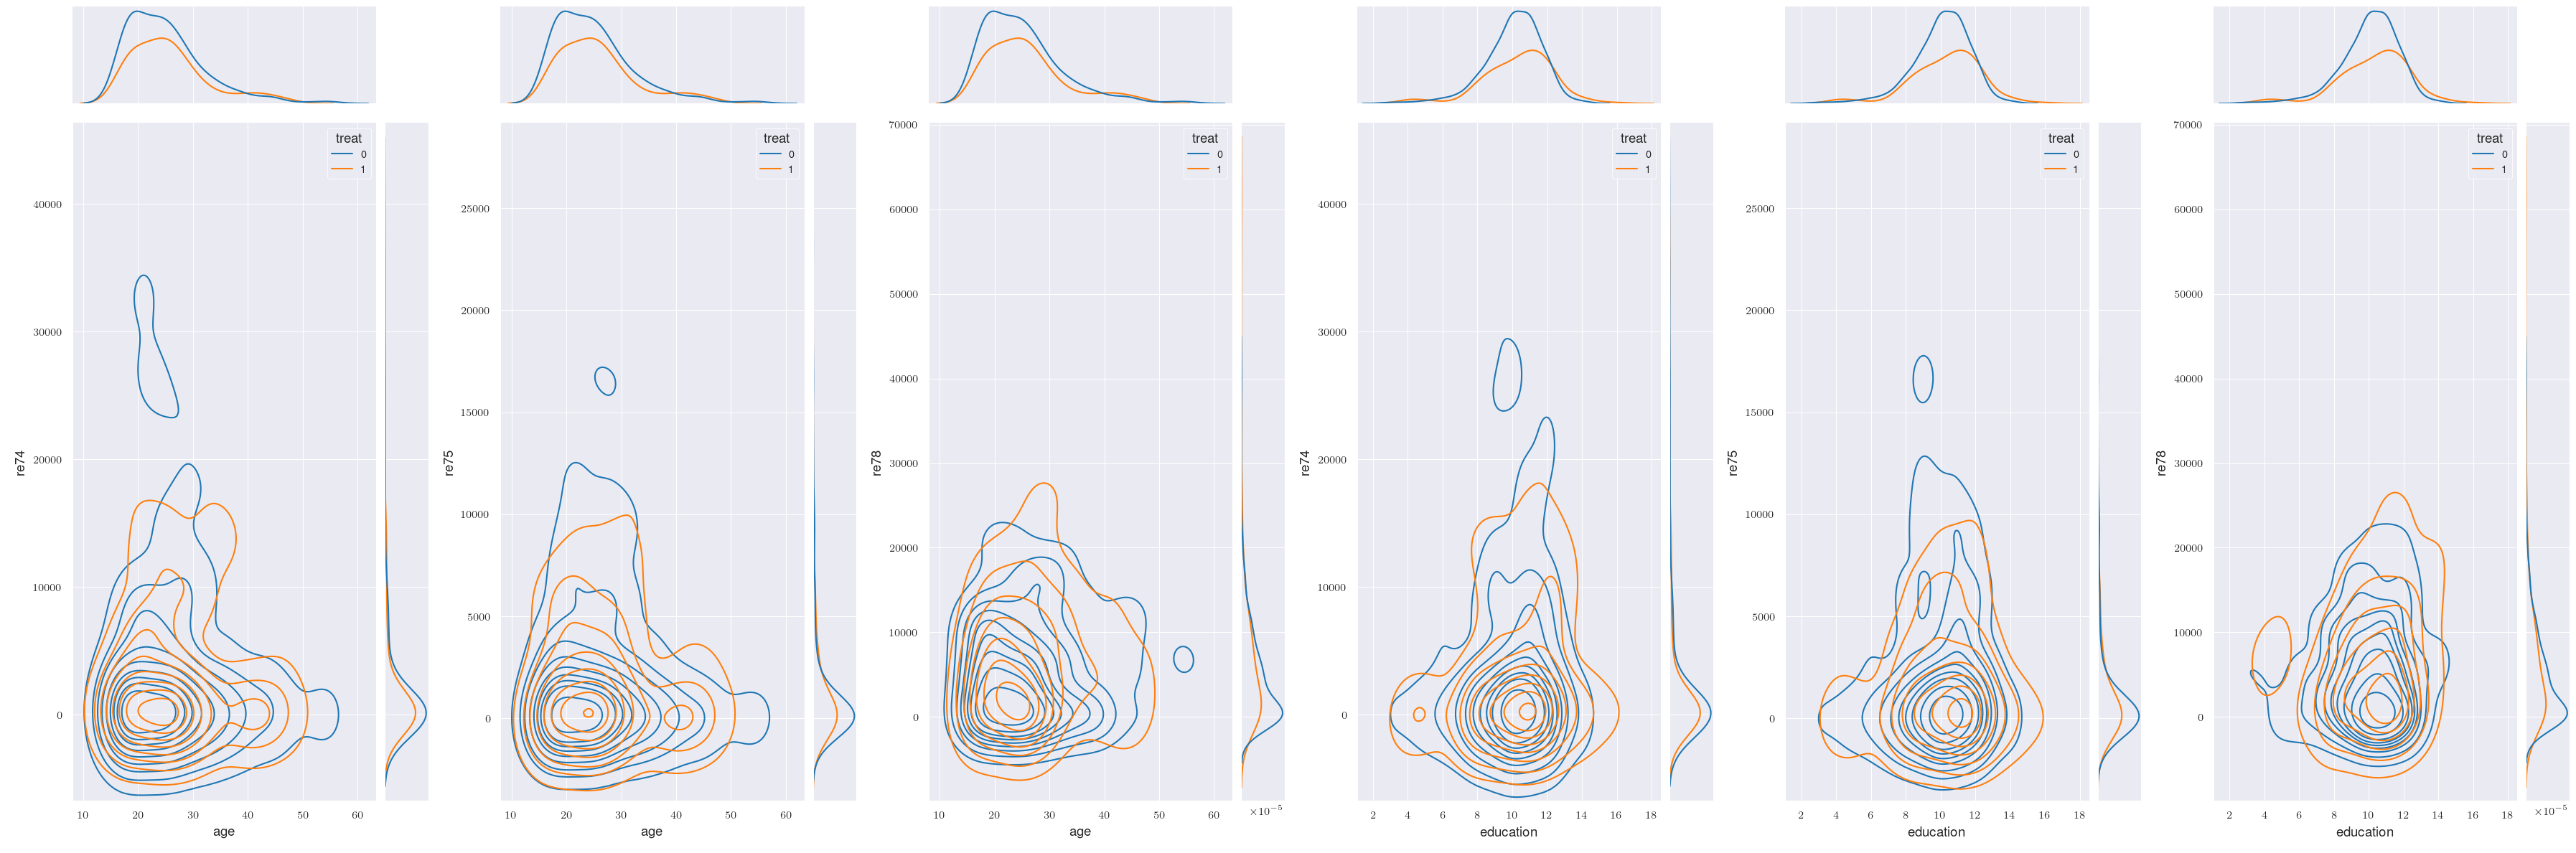

In [77]:
sns.set_style('darkgrid')

plot_kind = 'kde'
hue = 'treat'

g0 = sns.jointplot(data= nswre74_pd_df,x="age",y="re74", hue= hue, kind=plot_kind)
g1 = sns.jointplot(data= nswre74_pd_df,x="age",y="re75", hue= hue, kind=plot_kind)
g2 = sns.jointplot(data= nswre74_pd_df,x="age",y="re78", hue= hue, kind=plot_kind)
g3 = sns.jointplot(data= nswre74_pd_df,x="education",y="re74", hue= hue, kind=plot_kind)
g4 = sns.jointplot(data= nswre74_pd_df,x="education",y="re75", hue= hue, kind=plot_kind)
g5 = sns.jointplot(data= nswre74_pd_df,x="education",y="re78", hue= hue, kind=plot_kind)


fig = plt.figure(figsize=(24,8))
gs = gridspec.GridSpec(1,6)

mg0 = SeabornFigToGrid(g0, fig, gs[0])
mg1 = SeabornFigToGrid(g1, fig, gs[1])
mg2 = SeabornFigToGrid(g2, fig, gs[2])
mg3 = SeabornFigToGrid(g3, fig, gs[3])
mg4 = SeabornFigToGrid(g4, fig, gs[4])
mg5 = SeabornFigToGrid(g5, fig, gs[5])

gs.tight_layout(fig)


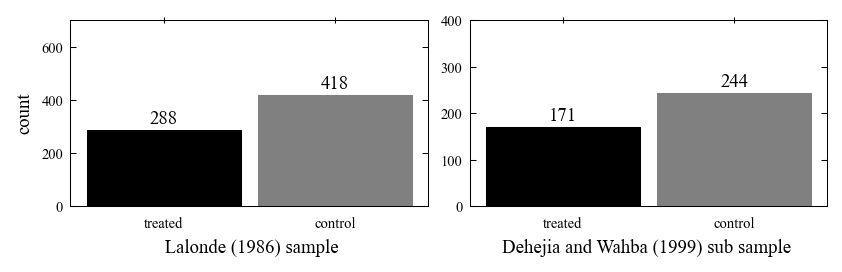

In [357]:
# Plot the balance of classes in the datasets 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

# Lalonde sample 
nswTreated = nsw_pd_df[nsw_pd_df['treat']==1]
nswControl = nsw_pd_df[nsw_pd_df['treat']==0]
nsw_heights = [len(nswTreated),len(nswControl)]

# Dehejia & Wahba subsample 

nswRe74_Treated = nswre74_pd_df[nswre74_pd_df['treat']==1]
nswRe74_Control = nswre74_pd_df[nswre74_pd_df['treat']==0]
nswRe74_heights = [len(nswRe74_Treated),len(nswRe74_Control),]

# Update plot paramaters 
fig, ax = plt.subplots(nrows=1, ncols=2)

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
plt.rcParams.update(fontsizes.neurips2022())

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Lalonde sample  bar plot 

# Lalonde sample
ax[0].set_facecolor('white')
ax[0].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
ax[0].grid(color='white', axis='x', linestyle='--', linewidth=1, alpha=1)
ax[0].set_ylim(0,700)

ax[0].spines['left']
ax[0].spines['bottom']
ax[0].spines['top']

ax[0].tick_params(right='on')
ax[0].tick_params(left='on')
ax[0].tick_params(top='on')

ax[0].set_xlabel(" Lalonde (1986) sample")
ax[0].set_ylabel("count")

bar = ax[0].bar(['treated','control'],nsw_heights,width = 0.9)
# colour chart 
bar[1].set_color('grey')
bar[0].set_color('black')

# Add counts to bar chart - lalonde sample 
for rect in ax[0].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[0].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Dehejia & Wahba subsample  bar plot 

ax[1].set_facecolor('white')
ax[1].grid(color='white', axis='y', linestyle='--', linewidth=1, alpha=1)
ax[1].grid(color='white', axis='x', linestyle='--', linewidth=1, alpha=1)
ax[1].set_ylim(0,400)

ax[1].spines['left']
ax[1].spines['bottom']
ax[1].spines['top']

bar2 = ax[1].bar(['treated','control'],nswRe74_heights, width = 0.9)

# colour chart 
bar2[1].set_color('grey')
bar2[0].set_color('black')
ax[1].set_xlabel("Dehejia and Wahba (1999) sub sample ")

# tick mark paramaters 
ax[1].tick_params(right='on')
ax[1].tick_params(left='on')
ax[1].tick_params(top='on')


 # Add counts to bar chart - dehejia wahba sample 
for rect in ax[1].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[1].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')   

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Save and display 
plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig1_classImbalance_bar_chart.png', bbox_inches='tight')
plt.show()


#### Data pre-processing for NN 

In [80]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

nswre74_pd_df.drop(nswre74_pd_df[nswre74_pd_df['re75'] > np.percentile(nswre74_pd_df['re75'] , 99)].index, inplace = True) # Drop variables above the 95th percentile 
nswre74_pd_df.drop(nswre74_pd_df[nswre74_pd_df['re78'] > np.percentile(nswre74_pd_df['re78'] , 99)].index, inplace = True) # Drop variables above the 95th percentile 

nsw_pd_df.drop(nsw_pd_df[nsw_pd_df['re75'] > np.percentile(nsw_pd_df['re75'] , 99)].index, inplace = True) # Drop variables above the 95th percentile 
nsw_pd_df.drop(nsw_pd_df[nsw_pd_df['re78'] > np.percentile(nsw_pd_df['re78'] , 99)].index, inplace = True) # Drop variables above the 95th percentile 

# Standardize continous variables 
nswre74_pd_df[['age','education','re74','re75','re78']] = sc.fit_transform(nswre74_pd_df[['age','education','re74','re75','re78']])
nsw_pd_df[['age','education','re75','re78']] = sc.fit_transform(nsw_pd_df[['age','education','re75','re78']])



# Original lalonde (1986) sample 
features_noRe74_df = nsw_pd_df.drop('treat', axis=1)
target_noRe74_df = nsw_pd_df.iloc[:,0]

features_noRe74_array = np.array(features_noRe74_df)
target_noRe74_array = np.array(target_noRe74_df)

FEATURES_noRe74 = torch.tensor(features_noRe74_array)
TARGET_noRe74 = torch.tensor(target_noRe74_array).unsqueeze(1)

# Dehejia and wahba (1999) sample 
features_df = nswre74_pd_df.drop('treat', axis=1)
target_df = nswre74_pd_df.iloc[:,0]

features_array = np.array(features_df)
target_array = np.array(target_df)

FEATURES_Re74 = torch.tensor(features_array)
TARGET_Re74 = torch.tensor(target_array).unsqueeze(1)
print(features_noRe74_array.shape,target_noRe74_df.shape)

(706, 8) (706,)


simulated_dataset
simulated_dataset = shuffle(simulated_dataset).reset_index(drop=True)

features_df  = simulated_dataset.drop('assignment', axis=1)
target_df = simulated_dataset.drop(['outcome','X0','X1','X2','X3','X4','X5','X6','X7','X8','X9'], axis=1)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
simulated_dataset[['outcome','X0','X1','X2','X3','X4','X5','X6','X7','X8','X9']] = sc.fit_transform(simulated_dataset[['outcome','X0','X1','X2','X3','X4','X5','X6','X7','X8','X9']])
# Standardize continous variables 

features_array = np.array(features_df)
target_array = np.array(target_df)

FEATURES = torch.tensor(features_array)
TARGET = torch.tensor(target_array)



#### Custom class for datasets

In [81]:
class CustomDataset:
  def __init__(self,features,target):    
    # load data
    self.features = features             
    self.target = target                
  
  def __len__(self):
    """
    Returns length of dataset.
    """

    return len(self.features)

  def __getitem__(self,idx):

    """
    Returns features and target with index idx.
    """
  
    features = self.features[idx]
    target = self.target[idx]
    return (features, target)
 

In [82]:
class CustomDataset:
  def __init__(self,features,target):    
    
    #import features and targets  
    self.features = features              
    self.target = target               
  
  def __len__(self):
    """
    Returns length of the dataset.
    """
    return len(self.features)

  def __getitem__(self,idx):
    """
    Returns features and target with index idx.
    """
    features = self.features[idx]
    target = self.target[idx]

    # convert data to array
    features_array = np.array(features)
    target_array = np.array(target)
    #convert to tensor 
    features = torch.tensor(features_array).float()
    target = torch.tensor(target_array).float()
    
    return (features, target)

####  Construct NN

<p> set hyper parameters </p>

### Model 

In [83]:
# Define neural netowork class 
class threelayerNN(nn.Module):
    def __init__(self, num_features, num_classes, num_hidden_1, num_hidden_2,num_hidden_3,num_hidden_4,num_hidden_5):
        super(threelayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.hidden_layer2 =  nn.Linear(num_hidden_2, num_hidden_3) 
        self.hidden_layer3 =  nn.Linear(num_hidden_3, num_hidden_4) 
        self.hidden_layer4 =  nn.Linear(num_hidden_4, num_hidden_5)
        self.hidden_layer5 =  nn.Linear(num_hidden_5, num_classes) 
    
        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        self.batchnorm3 = nn.BatchNorm1d(num_hidden_3)
        self.batchnorm4 = nn.BatchNorm1d(num_hidden_4)
        self.batchnorm5 = nn.BatchNorm1d(num_hidden_5)
    
    # Forward propogation method
    def forward(self, x):
        # input 
        x = self.input_layer(x)
        x = self.relu_activation(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)
        # first hidden layer
        x = self.hidden_layer1(x)
        x = self.relu_activation(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)
        # second hidden layer and output
        x = self.hidden_layer2(x)
        x = self.relu_activation(x)
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.hidden_layer3(x)
        x = self.relu_activation(x)
        x = self.batchnorm4(x)
        x = self.dropout(x)
        x = self.hidden_layer4(x)
        x = self.relu_activation(x)
        x = self.batchnorm5(x)
        x = self.dropout(x)
        x = self.hidden_layer5(x)
        x = self.output_activation(x)
        return x


class twoLayerNN(nn.Module):
    def __init__(self,num_features, num_classes, num_hidden_1, num_hidden_2):
        super(twoLayerNN, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation functions
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)

    # Forward propogation method
    def forward(self, inputs):
        x = self.relu_activation(self.input_layer(inputs))
        x = self.batchnorm1(x)
        x = self.relu_activation(self.hidden_layer1(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.output_activation(self.out_layer(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





<p> NN helper functions </p>

In [84]:
# Function to reset model weights 
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    #print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [85]:
# Function to initialise model weights 
def initialize_weights(m):
    classname = m.__class__.__name__
    # For every linear layer in the mdoel   
    if classname.find('Linear') != -1:
     n = m.in_features
     y = 1.0/np.sqrt(n)
     m.weight.data.uniform_(-y, y)
     m.bias.data.fill_(0)
    

### K-fold cross validation

<p> Initial settings <p>

In [195]:
# Set model hyper parameters 
NUM_FEATURES = FEATURES_Re74.shape[1]
NUM_HIDDEN_1 = 64
NUM_HIDDEN_2 = 32
NUM_HIDDEN_3 = 15
NUM_HIDDEN_4 = 15 
NUM_HIDDEN_5 = 15          
NUM_CLASSES = 1
NUM_EPOCHS = 50
BATCH_SIZE = 64

LEARNING_RATE = 0.01

# training configuration options  
K_FOLDS = 5     
splits = KFold(n_splits=K_FOLDS,shuffle=True,random_state=42)

In [196]:
# Dictionaries to store results  
validation_accuracy_dict = {}      
validation_loss_dict = {}
training_accuracy_dict = {}
training_loss_dict = {}
foldperf = {}
acc_per_epoch = {}
fold_validation_accuracy = {}


In [197]:
# Function to calculate accuracy 
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

### Cross validation 

In [198]:
# set seed
torch.manual_seed(1)

In [199]:
kfold = KFold(n_splits= K_FOLDS, shuffle=True)
dataset = CustomDataset(features = FEATURES_Re74,target = TARGET_Re74)

In [200]:
print("==========  start =============")  

for fold, (train_ids, test_ids) in enumerate(splits.split(np.arange(len(dataset)))):
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)
    # Define data loaders for training and testing data in this fold
    
    trainloader = DataLoader(dataset,  batch_size=BATCH_SIZE, sampler=train_subsampler)
    testloader = DataLoader(dataset,batch_size=BATCH_SIZE, sampler=test_subsampler)

    # Instanstiate model 
    #model = threelayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2,num_hidden_3 = NUM_HIDDEN_3,
    #num_hidden_4 = NUM_HIDDEN_4,num_hidden_5 = NUM_HIDDEN_5)
    model = twoLayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2)
    model.to(device)
    # Reset weights 
    #model.apply(reset_weights)
    model.apply(initialize_weights)
    #Initialise optimiser and loss function 
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    metrics = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    # Run training and validation n epochs  
    for epoch in range(0, NUM_EPOCHS):
        # Training variables 
        running_training_loss = 0.0
        total_training_samples = 0 
        train_correct = 0
        train_accuracy = 0
        #set model to training mode
        model.train()
        print('==========  Training ==========') 
        for idx, (features,target) in enumerate(trainloader,start = 0):       # Iterate over the DataLoader for training data

            # GET DATA  
            target_tensor = target
            train_features = features.float().to(device)
            train_target = target.float().to(device)
            train_outputs = model(train_features)
      
            # COMPUTE LOSS
            loss = criterion(train_outputs , train_target)
             # ZERO PARAMETER GRADIENTS  
            optimizer.zero_grad()
            loss.backward()
            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # ========== TRAINING LOGGING ========== #

            #calculate training accuracy
            # At the completion of each epoch , store train losses 
            train_prediction = (train_outputs >= 0.5).type(torch.uint8) 
            running_training_loss += loss.item()*train_features.size(0)
            training_loss  = running_training_loss / len(trainloader.sampler)
            train_correct += (train_prediction == train_target).numpy().sum()

        # STORE AND LOG TRAINING INFORMATION
        train_accuracy = train_correct/len(trainloader.sampler)*100
        training_accuracy_dict[(fold,epoch)] = train_accuracy.item()
        training_loss_dict[(fold,epoch)] = training_loss
        print(f'Fold: {fold}'f' | Epoc: {epoch+1}/{NUM_EPOCHS} 'f' | Training Loss: {training_loss:.4f}'f'| Training accuracy: {train_accuracy:.2f}')

        with torch.no_grad():
            total_validation_samples = 0 
            running_validation_loss = 0
            val_correct = 0
            validation_acc = 0
            model.eval()
            print('==========  Validating ==========') 
            for idx, (features,target) in enumerate(testloader): # Iterate over the test data and generate predictions
                
                val_target_tensor = target
                val_inputs = features.float().to(device)
                val_targets = target.float().to(device) 
                val_outputs = model(val_inputs)

                loss = criterion(val_outputs , val_targets)

                # ========== VALIDATION LOGGING ========== # 

                prediction = (val_outputs >= 0.5).type(torch.uint8) 
                running_validation_loss += loss.item()*val_inputs.size(0)
                validation_loss = running_validation_loss / len(testloader.sampler)
                val_correct += (prediction == val_targets).numpy().sum()

            # STORE AND LOG VALIDATION INFORMATION 
            validation_acc = val_correct/len(testloader.sampler)*100
            validation_accuracy_dict[(fold,epoch)] = validation_acc.item()
            validation_loss_dict[(fold,epoch)] = validation_loss  
            print(f'Fold: {fold}'f' | Epoc: {epoch+1}/{NUM_EPOCHS} | Valid Loss: {validation_loss:.2f}'f'| Validation accuracy: {validation_acc:.2f}')
        #validation_acc = val_correct/len(testloader)
          # * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
# Print fold results
torch.save(model.state_dict(), '/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/k_cross_ANN.pt')


validation_accuracy_list = list(validation_accuracy_dict.values())
average_validation_acc = np.sum(validation_accuracy_list)/len(validation_accuracy_list)
training_accuracy_list = list(training_accuracy_dict.values())
average_training_acc = np.sum(training_accuracy_list)/len(training_accuracy_list)

print(f'K-FOLD CROSS VALIDATION RESULTS FOR {K_FOLDS} FOLDS')

print(f'AVG valdiation acc: {average_validation_acc:.2f}| 'f'AVG training acc: {average_training_acc:.2f}')


==========  start =============
==========  Training ==========
Fold: 0 | Epoc: 1/50  | Training Loss: 0.7619| Training accuracy: 53.61
==========  Validating ==========
Fold: 0 | Epoc: 1/50 | Valid Loss: 0.75| Validation accuracy: 59.04
==========  Training ==========
Fold: 0 | Epoc: 2/50  | Training Loss: 0.7225| Training accuracy: 64.46
==========  Validating ==========
Fold: 0 | Epoc: 2/50 | Valid Loss: 0.73| Validation accuracy: 56.63
==========  Training ==========
Fold: 0 | Epoc: 3/50  | Training Loss: 0.7163| Training accuracy: 63.25
==========  Validating ==========
Fold: 0 | Epoc: 3/50 | Valid Loss: 0.72| Validation accuracy: 57.83
==========  Training ==========
Fold: 0 | Epoc: 4/50  | Training Loss: 0.6984| Training accuracy: 65.06
==========  Validating ==========
Fold: 0 | Epoc: 4/50 | Valid Loss: 0.71| Validation accuracy: 61.45
==========  Training ==========
Fold: 0 | Epoc: 5/50  | Training Loss: 0.6912| Training accuracy: 65.66
==========  Validating ==========
Fold: 

In [201]:
#print("Model's state_dict:")
#for param_tensor in model.state_dict():
#    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

In [202]:
validation_acc = list(validation_accuracy_dict.values())
average_validation_acc = np.sum(validation_acc)/len(validation_acc)
training_acc = list(training_accuracy_dict.values())
average_validation_acc = np.sum(training_acc)/len(training_acc)

### Plot training summary 

In [203]:
# Convert accuracy and loss dictionaries to lists 
validation_accurary_list = list(validation_accuracy_dict.values())
validation_loss_list = list(validation_loss_dict.values())
training_accuracy_list = list(training_accuracy_dict.values())
training_loss_list = list(training_loss_dict.values())

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


<function matplotlib.pyplot.show(close=None, block=None)>

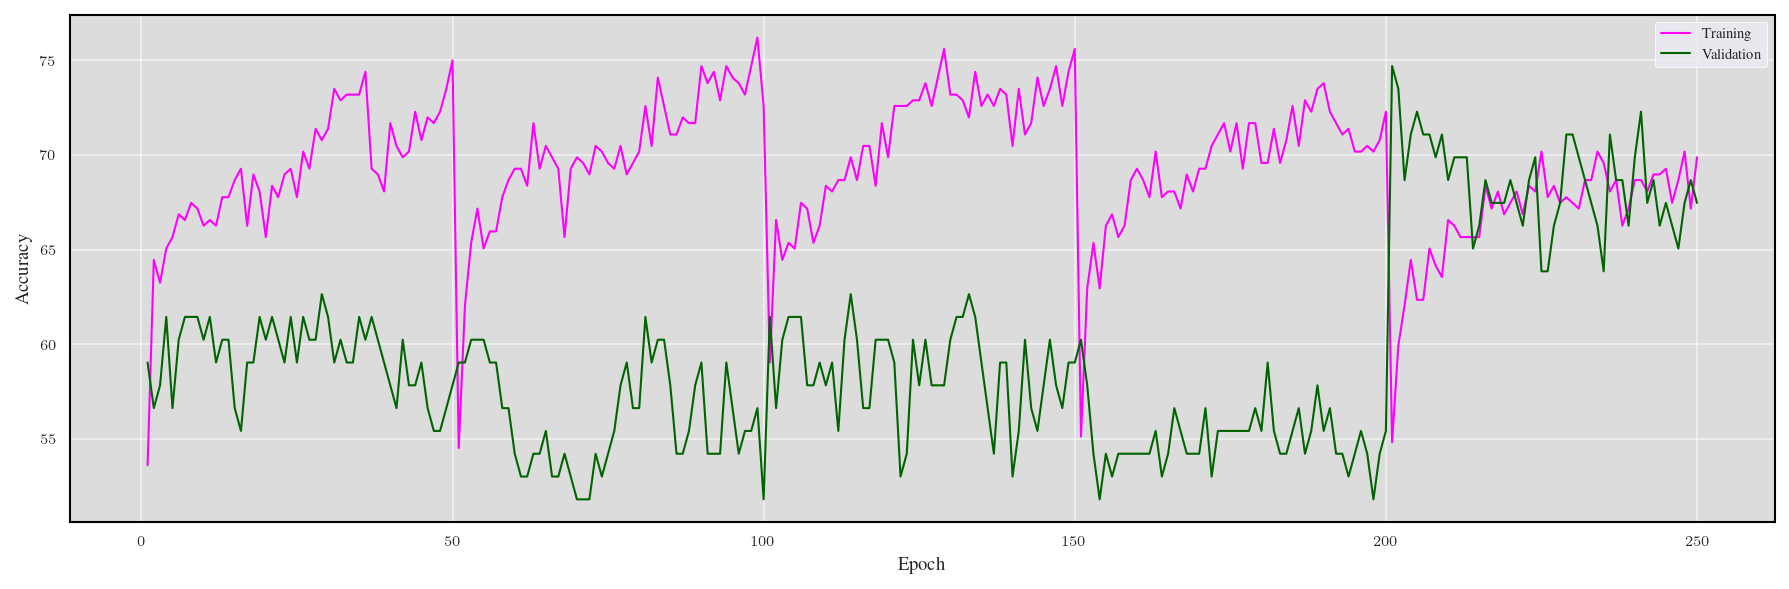

In [204]:
fig, ax = plt.subplots(figsize=(12,4))

ax.set_facecolor('gainsboro')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='white', axis='x', linestyle='-', linewidth=1, alpha=0.5)
ax.grid(color='white', axis='y', linestyle='-', linewidth=1, alpha=0.5)

epochs_train = len(training_accuracy_list)
epochs_val = len(validation_accurary_list)

plt.plot(np.arange(1, epochs_train+1),training_accuracy_list, label='Training',color='magenta')
plt.plot(np.arange(1, epochs_val+1),validation_accurary_list, label='Validation',color='darkgreen')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

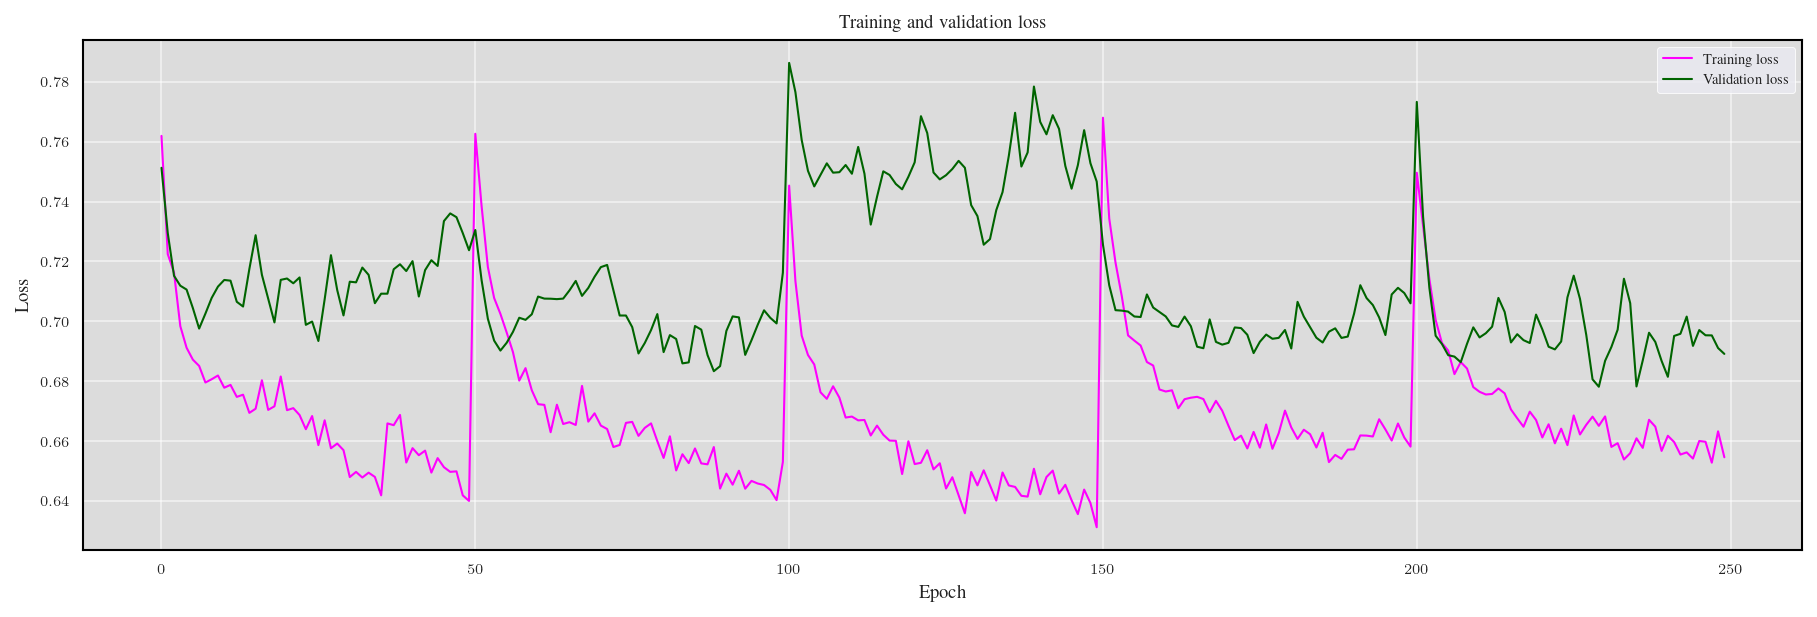

In [205]:
# Plot training and validation losses 

# Use to plots to clean up the presentation 
from tueplots import bundles 
from tueplots import figsizes
from tueplots import axes

# tueplots paramaters 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(axes.lines())


figsizes.neurips2021(nrows=3)["figure.figsize"]
plt.rcParams.update({"figure.dpi": 150})

fig, ax = plt.subplots(figsize=(12,4))

ax.set_facecolor('gainsboro')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='white', axis='x', linestyle='-', linewidth=1, alpha=0.5)
ax.grid(color='white', axis='y', linestyle='-', linewidth=1, alpha=0.5)

ax.plot(training_loss_list, label='Training loss',color='magenta')
ax.plot(validation_loss_list, label='Validation loss',color = 'darkgreen')


ax.set_title(' Training and validation loss ')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')


ax.legend()


plt.show



In [298]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score



<AxesSubplot:>

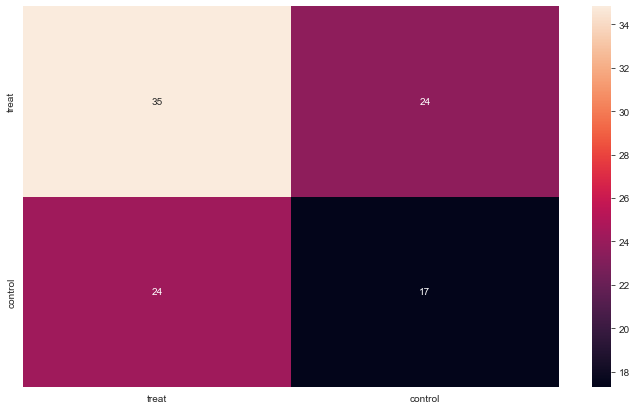

In [294]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

dataset = CustomDataset(features = FEATURES_Re74,target = TARGET_Re74)
trainloader = DataLoader(dataset,  batch_size=BATCH_SIZE)


model = twoLayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2)
model.apply(initialize_weights)
# iterate over test data
for idx,(features,target) in enumerate(trainloader,start = 0):
        features = features.float().to(device)
        target = target.float().to(device)
       
        output = model(features) # Feed Network
        outputs = ((output >= 0.5).type(torch.uint8)).numpy()
        y_pred.extend(outputs) # Save Prediction
        
        target = target.numpy()
        y_true.extend(target) # Save Truth


# constant for classes
classes = ('treat', 'control')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = [i for i in classes],columns = [i for i in classes])

plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
                                              

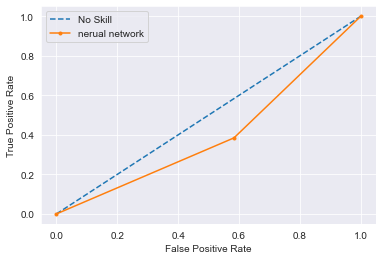

In [318]:
# Plot ROC curves 


outputs_pos = outputs == 1

ns_probs = [0 for _ in range(len(target))]

ns_auc = roc_auc_score(target, ns_probs)
lr_auc = roc_auc_score(target, outputs_pos)

ns_fpr, ns_tpr, _ = roc_curve(target, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(target, outputs_pos)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='nerual network')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [21]:
# Explaining model 

import shap
shap_values = shap.TreeExplainer(model).shap_values(FEATURES_Re74)
shap.summary_plot(shap_values, FEATURES_Re74, plot_type="bar")

explainer = shap.DeepExplainer(pipeline.model, encoded_x_train[:10])
shap_values = explainer.shap_values(encoded_x_test[:1])

InvalidModelError: Model type not yet supported by TreeExplainer: <class '__main__.twoLayerNN'>

In [331]:
np.__version__

'1.23.1'

<p> Plot loss and accuracy </p>

### Validating model 

In [106]:

model = threelayerNN(num_features = NUM_FEATURES,num_classes  = NUM_CLASSES, num_hidden_1 = NUM_HIDDEN_1,num_hidden_2 = NUM_HIDDEN_2,num_hidden_3 = NUM_HIDDEN_3)

model.apply(initialize_weights)

y_pred = []
y_true = []

for idx,(features,target) in enumerate(validation_loader,start = 0):

        features = features.float().to(device)
        target = target.float().to(device)
       
        output = model(features) # Feed Network
        pred = (torch.round(torch.sigmoid(output))).detach().numpy()

        y_pred.extend(pred) # Save Prediction
        
        target = target.numpy()
        y_true.extend(target) # Save Truth

      